<a id='top'></a>

# ÍNDEX
*****

<ul>1. <a href='#importlibraries'>Librerías utilizadas</a></ul>
<ul>2. <a href='#loaddata'>Carga de datos</a></ul>
<ul><ul>2.1. <a href='#dataframe'>Carga de Dataframe</a></ul></ul>
<ul><ul>2.2. <a href='#loadimages'>Carga de Imágenes</a></ul></ul>
<ul>3. <a href='#dataexplo'>Exploración analítica de datos</a></ul>
<ul><ul>3.1. <a href='#histograms'>Histogramas</a></ul></ul>
<ul><ul>3.2. <a href='#plotsvstarget'>Representación visual de variables frente al 'Target'</a></ul></ul>
<ul><ul>3.3. <a href='#correlationmatrix'>Matriz de correlaciones</a></ul></ul>
<ul><ul>3.4. <a href='#categoricalvariables'>Variables categóricas</a></ul></ul>
<ul>4. <a href='#dataprep'>Preparación de datos</a></ul>
<ul><ul>4.1. <a href='#fillna'> Imputación de valores no disponibles</a></ul></ul>
<ul><ul>4.2. <a href='#dummies'>Variables dummy</a></ul></ul>
<ul><ul>4.3. <a href='#dropvariables'>Eliminación de atributos sin relevancia</a></ul></ul>
<ul>5. <a href='#featureselection'>Selección de variables</a></ul>

* <a href='#functions'>Apéndice 1: Funciones</a>


<a id='importlibraries'></a> 

### 1. Librerias utilizadas  <p style="text-align: right;"> <a href='#top'>Return to top</a> </p>


In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import cv2
import glob
import copy
import scipy.misc as scpm
from collections import Counter
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error

%matplotlib inline

<a id='loaddata'></a> 
### 2. Carga de datos  <p style="text-align: right;"> <a href='#top'>Return to top</a> </p>

<a id='dataframe'></a> 
#### 2.1. Carga de Dataframe <p style="text-align: right;">

In [2]:
modelar= pd.read_csv('data/Modelar_UH2019.txt', sep="|")
estimar = pd.read_csv('data/Estimar_UH2019.txt', sep="|")

print('Modelar:', modelar.shape, 'Estimar:', estimar.shape)

Modelar: (9958, 53) Estimar: (1104, 52)


In [3]:
modelar.head(3)

,HY_id,HY_cod_postal,HY_provincia,HY_descripcion,HY_distribucion,HY_tipo,HY_antiguedad,HY_metros_utiles,HY_metros_totales,HY_num_banos,...,IDEA_unitprice_rent_residential,IDEA_price_rent_residential,IDEA_stock_rent_residential,IDEA_demand_rent_residential,GA_page_views,GA_mean_bounce,GA_exit_rate,GA_quincena_ini,GA_quincena_ult,TARGET
0,6028499,18151,Granada,Plaza de Garaje ubicada en la planta sótano de...,NaN,Garaje,NaN,NaN,35.00,0,...,5.09,626.38,237.0,51.01,71,7.14,10.65,2,46,32.16
1,6028500,29915,Málaga,NaN,NaN,Casa de pueblo,NaN,NaN,151.98,2,...,4.08,700.00,6.0,50.69,684,16.36,5.25,1,47,30.71
2,6028502,3740,Alicante,El inmueble(piso) se encuentra situado en el d...,VIVIENDA-PISO,Piso,2008.0,92.58,102.78,1,...,4.43,525.00,15.0,51.82,651,15.12,11.21,1,47,63.48


<a id='loadimages'></a> 

#### 2.2. Carga de Imágenes <p style="text-align: right;"> <a href='#top'>Return to top</a> </p>


In [4]:
#Función para cargar todas las imágenes en la carpeta:
def load_images(filenames):
    images = np.asarray([scpm.imread(file) for file in filenames])
    return images

#Se obtienen los nombres de los archivos en la carpeta:
names = sorted(glob.glob('imagenes_inmuebles_haya/*.jpg'))
print('Número total de imágenes cargadas:', len(names))

lista=[names[i][24:31] for i in range(len(names))]

#Cantidad de imágenes por HY_id
num_images=pd.DataFrame(Counter(lista), index=['num_images']).transpose()
num_images=num_images.reset_index()
num_images['index']=num_images['index'].astype(int)
num_images.head()

Número total de imágenes cargadas: 47382


,index,num_images
0,6028499,5
1,6028500,3
2,6028502,10
3,6028512,2
4,6028513,2


Se incorpora una nueva variable *num_images*, que cuenta la cantidad de imágenes disponibles por anuncio, al dataframe:

In [5]:
modelar=pd.merge(modelar, num_images, left_on='HY_id', right_on='index')
modelar.drop(['index'], axis=1, inplace = True)

#### Nota: 
La imagen *'6031545__posifoto3__1K9lJvlehV.jpg'* ha sido eliminada al estar corrupta y no poder visualizarse:

        import os 
        os.remove("imagenes_inmuebles_haya\\6031545__posifoto3__1K9lJvlehV.jpg")


<a id='dataexplo'></a> 

### 3. Exploración analítica de datos <p style="text-align: right;"> <a href='#top'>Return to top</a> </p>



Se añade una variable *Descr_len* que mide la longitud de la descripción de la vivienda en el anuncio:

In [6]:
modelar['descr_len']= modelar['HY_descripcion'].str.len()
modelar.head(3)

,HY_id,HY_cod_postal,HY_provincia,HY_descripcion,HY_distribucion,HY_tipo,HY_antiguedad,HY_metros_utiles,HY_metros_totales,HY_num_banos,...,IDEA_stock_rent_residential,IDEA_demand_rent_residential,GA_page_views,GA_mean_bounce,GA_exit_rate,GA_quincena_ini,GA_quincena_ult,TARGET,num_images,descr_len
0,6028499,18151,Granada,Plaza de Garaje ubicada en la planta sótano de...,NaN,Garaje,NaN,NaN,35.00,0,...,237.0,51.01,71,7.14,10.65,2,46,32.16,5,397.0
1,6028500,29915,Málaga,NaN,NaN,Casa de pueblo,NaN,NaN,151.98,2,...,6.0,50.69,684,16.36,5.25,1,47,30.71,3,NaN
2,6028502,3740,Alicante,El inmueble(piso) se encuentra situado en el d...,VIVIENDA-PISO,Piso,2008.0,92.58,102.78,1,...,15.0,51.82,651,15.12,11.21,1,47,63.48,10,226.0


En primer lugar se encuentran los valores no disponibles (*Missing Values*) para cada una de las variables:

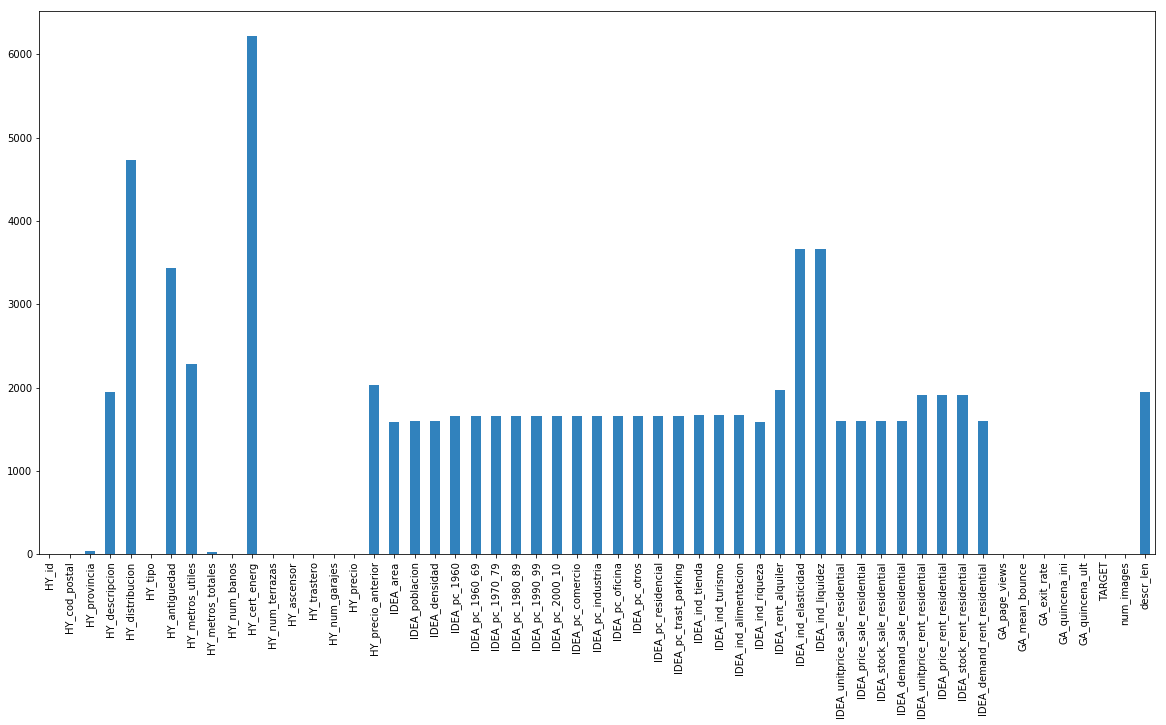

HY_id                   0
HY_cod_postal           0
HY_provincia           37
HY_descripcion       1945
HY_distribucion      4733
HY_tipo                 0
HY_antiguedad        3434
HY_metros_utiles     2280
HY_metros_totales      30
HY_num_banos            0
dtype: int64     ...


In [7]:
missing_val_count=modelar.isnull().sum()
missing_val_count.plot(kind='bar',figsize=(20,10),colormap='tab20c')
plt.show()
print(missing_val_count[0:10],'    ...')

Se observa la provincia de origen de las publicaciones de anuncios en idealista, con el objetivo de estudiar su efecto en la variable objetivo:

In [8]:
modelar['HY_provincia'].value_counts()

Valencia       1700
Almería        1325
Murcia         1186
Castellón      1169
Alicante        641
Málaga          415
Granada         276
Tarragona       223
Valladolid      170
Barcelona       118
Las Palmas       96
Cádiz            55
Baleares         53
Madrid           52
La Rioja         45
Albacete         38
Soria            34
Gerona           27
Córdoba          21
Teruel           21
Guadalajara      19
A Coruña         16
León             16
Toledo           15
Palencia         13
Cuenca           11
Sevilla           9
Avila             8
Zaragoza          7
Pontevedra        5
Huelva            4
Lérida            4
Huesca            3
Ciudad Real       2
Burgos            2
Jaén              1
Tenerife          1
Segovia           1
Navarra           1
Asturias          1
Cáceres           1
Name: HY_provincia, dtype: int64

,TARGET
HY_provincia,
A Coruña,58.505625
Albacete,84.667368
Alicante,74.480546
Almería,68.052234
Asturias,62.950000
Avila,63.756250
Baleares,69.110755
Barcelona,82.695085
Burgos,39.730000


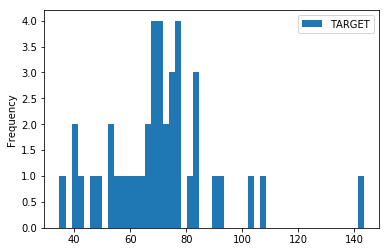

In [9]:
display(modelar[['HY_provincia', 'TARGET']].groupby(by = 'HY_provincia').mean().head(10))
modelar[['HY_provincia', 'TARGET']].groupby(by = 'HY_provincia').mean().plot(kind='hist', bins=50)
plt.show()

C:\ProgramData\Anaconda3\lib\site-packages\scipy\stats\stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


count    7842.000000
mean       72.832573
std        77.652940
min         0.000000
25%        33.662500
50%        58.235000
75%        89.167500
max      1770.000000
Name: TARGET, dtype: float64

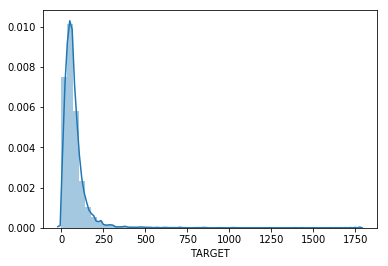

In [10]:
sns.distplot(modelar.TARGET);
modelar['TARGET'].describe()

Se descartan los valores atípicos de la variable objetivo, de manera que se conservan el 98.02% de los datos disponibles.

In [11]:
print(round(modelar.loc[modelar['TARGET']<300,].shape[0]/modelar.shape[0]*100,2),'%')

98.53 %


C:\ProgramData\Anaconda3\lib\site-packages\scipy\stats\stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


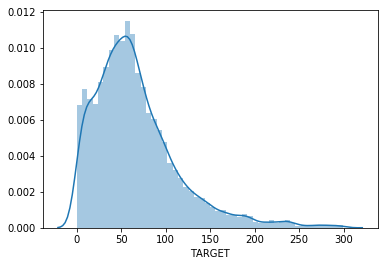

In [12]:
modelar = modelar.loc[modelar['TARGET']<300,]
sns.distplot(modelar.TARGET)

Se almacena el dataframe disponible en este punto, antes de continuar:

In [13]:
# modelar.to_csv('data/modelar_normalized.csv', index = False)

#### Variable: Descripción
***
Se dispone información de la descripción en 5811 muestras (59.53% del total) y 659 muestras del dataset de test (59.69% del total).

In [14]:
modelar['HY_descripcion'].count()

5811

In [15]:
estimar['HY_descripcion'].count()

659

<a id='histograms'></a> 

#### 3.1. Histogramas <p style="text-align: right;"> <a href='#top'>Return to top</a> </p>


In [16]:
modelar = pd.read_csv('data/modelar_normalized.csv')

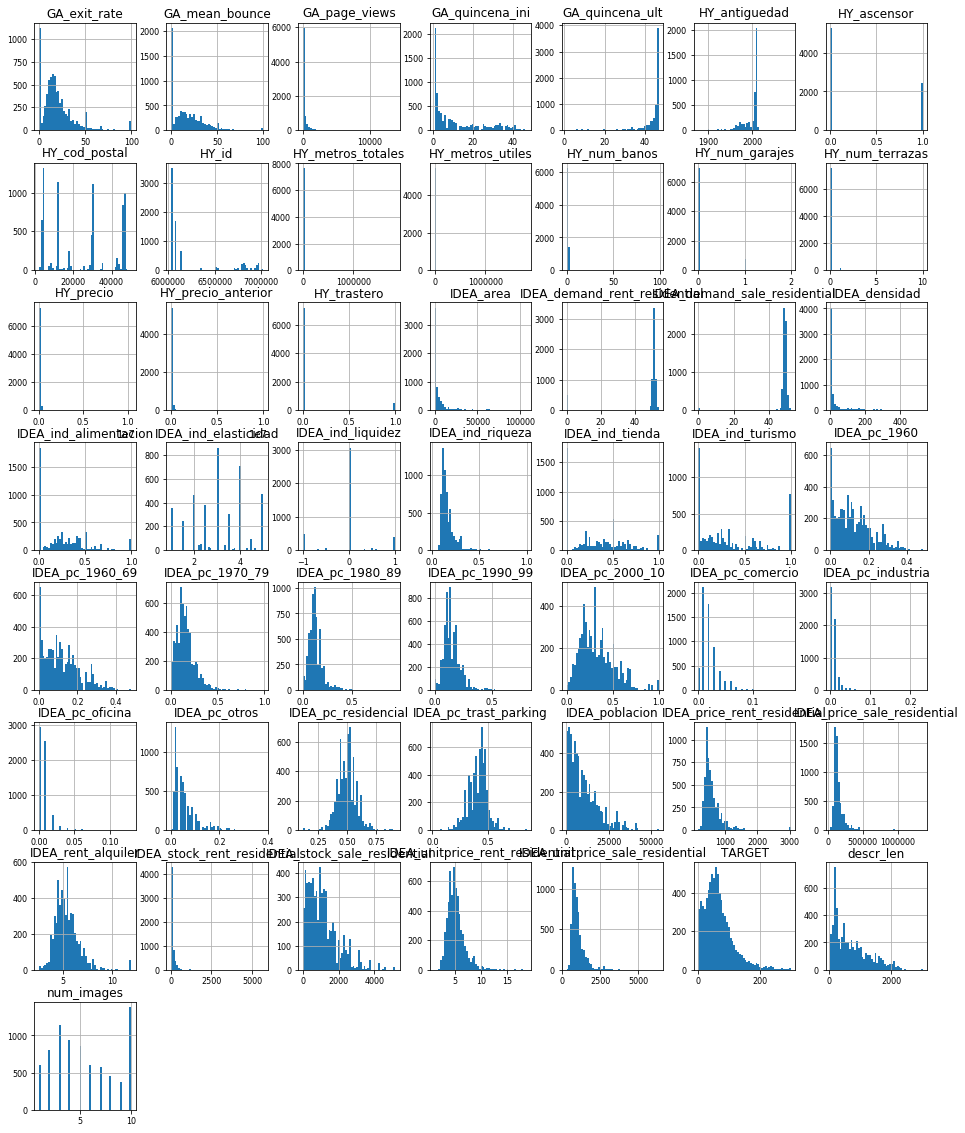

In [17]:
modelar.hist(figsize=(16, 20), bins=50, xlabelsize=8, ylabelsize=8)
plt.show()

#### Variable: HY_metros totales
***

In [18]:
modelar.loc[modelar['HY_metros_totales']>10000].head(3)

,HY_id,HY_cod_postal,HY_provincia,HY_descripcion,HY_distribucion,HY_tipo,HY_antiguedad,HY_metros_utiles,HY_metros_totales,HY_num_banos,...,IDEA_stock_rent_residential,IDEA_demand_rent_residential,GA_page_views,GA_mean_bounce,GA_exit_rate,GA_quincena_ini,GA_quincena_ult,TARGET,num_images,descr_len
1387,6035128,12006,Castellón,Parcela de tipo suelo urbano de forma irregula...,NaN,Solar,NaN,NaN,99999.0,0,...,78.0,52.10,689,30.35,23.28,1,47,188.14,4,155.0
2904,6042341,4117,Almería,"Parcela de terreno edificable, ubicada en el m...",NaN,Solar,NaN,NaN,14556.0,0,...,9.0,51.01,323,31.13,26.11,1,46,108.92,2,92.0
2905,6042342,4117,Almería,"Parcela de terreno edificable, ubicada en el m...",NaN,Solar,NaN,NaN,12976.0,0,...,15.0,50.25,33,0.00,4.29,1,44,156.05,1,92.0


#### Variables: Quincenas (GA_quincena_ini y GA_quincena_ult)
***

In [19]:
modelar[['GA_quincena_ini', 'GA_quincena_ult']].head(5)

,GA_quincena_ini,GA_quincena_ult
0,2,46
1,1,47
2,1,47
3,2,47
4,2,39


In [20]:
modelar.loc[modelar['HY_precio']>2000000]

,HY_id,HY_cod_postal,HY_provincia,HY_descripcion,HY_distribucion,HY_tipo,HY_antiguedad,HY_metros_utiles,HY_metros_totales,HY_num_banos,...,IDEA_stock_rent_residential,IDEA_demand_rent_residential,GA_page_views,GA_mean_bounce,GA_exit_rate,GA_quincena_ini,GA_quincena_ult,TARGET,num_images,descr_len
4249,6037826,8202,Barcelona,Local comercial en esquina integrado en dos ed...,"Cuenta con una superficie total de 1076, 64 m²...",Local,1960.0,NaN,2118.53,0,...,174.0,52.45,153,50.31,50.87,11,47,145.57,2,2031.0
4257,6038463,4001,Almería,NaN,NaN,Local,NaN,0.0,385.07,0,...,NaN,NaN,99,30.00,22.20,39,47,50.10,4,NaN
4354,6075912,29730,Málaga,NaN,NaN,Solar,NaN,0.0,10000.00,0,...,NaN,NaN,15,45.83,51.19,33,45,88.42,2,NaN
5386,6033399,4630,Almería,Terrenos urbanos en el Paraje La Espesura. Tie...,Terreno de superficie registral: 269.116 m².\r...,Solar,NaN,NaN,269116.00,0,...,54.0,51.70,426,22.22,17.42,1,47,97.46,10,918.0
6932,6811795,4007,Almería,NaN,NaN,Local,NaN,2200.0,2300.50,0,...,NaN,NaN,15,66.67,78.33,30,46,46.71,5,NaN
7236,6940987,46980,Valencia,NaN,NaN,Solar,NaN,2538.0,2538.00,0,...,72.0,51.84,29,16.67,24.17,38,47,38.72,3,NaN
7290,6946638,12520,Castellón,NaN,NaN,Solar,NaN,4226.0,4226.00,0,...,75.0,51.68,10,33.33,33.33,35,46,170.18,3,NaN
7690,7008680,50270,Zaragoza,NaN,NaN,Solar,NaN,1820000.0,1820000.00,0,...,9.0,51.10,27,22.50,13.89,39,42,166.80,3,NaN


#### Variable: Certificado energético (HY_cert_energ)
***
A pesar de no disponer de muchos datos de la variable, se observa que no es relevante frente a la variable objetivo

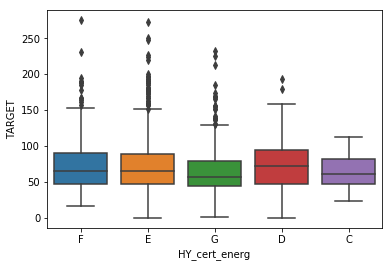

In [21]:
sns.boxplot(data = modelar[['HY_cert_energ', 'TARGET']], x = 'HY_cert_energ', y = 'TARGET')

In [22]:
modelar['HY_cert_energ'].unique()

array([nan, 'F', 'E', 'G', 'D', 'C'], dtype=object)

#### Variable: Ascensor (HY_ascensor)
***

A pesar de no disponer de muchos datos de la variable, se observa que no es relevante frente a la variable objetivo

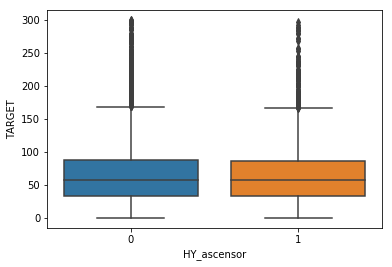

In [23]:
sns.boxplot(data = modelar[['HY_ascensor', 'TARGET']], x = 'HY_ascensor', y = 'TARGET')
plt.show()

#### Variable: Variables de población y densidad
***


In [24]:
def plot_target(column):
    modelar[[column, 'TARGET']].plot(x = column, y = 'TARGET', kind = 'scatter')

In [25]:
def plot_cat_target(column):
    fig, ax = plt.subplots(figsize = (10, 8))
    sns.boxplot(data = modelar[[column, 'TARGET']], x = column, y = 'TARGET')
    plt.xticks(rotation=45)

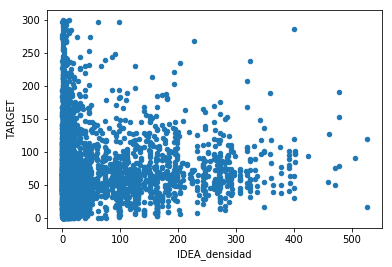

In [26]:
plot_target('IDEA_densidad')

<a id='plotsvstarget'></a> 

#### 3.2. Representación visual de variables frente al 'TARGET' <p style="text-align: right;"> <a href='#top'>Return to top</a> </p>


HY_provincia plot not possible
HY_descripcion plot not possible
HY_distribucion plot not possible
HY_tipo plot not possible
HY_cert_energ plot not possible
num_images plot not possible
descr_len plot not possible


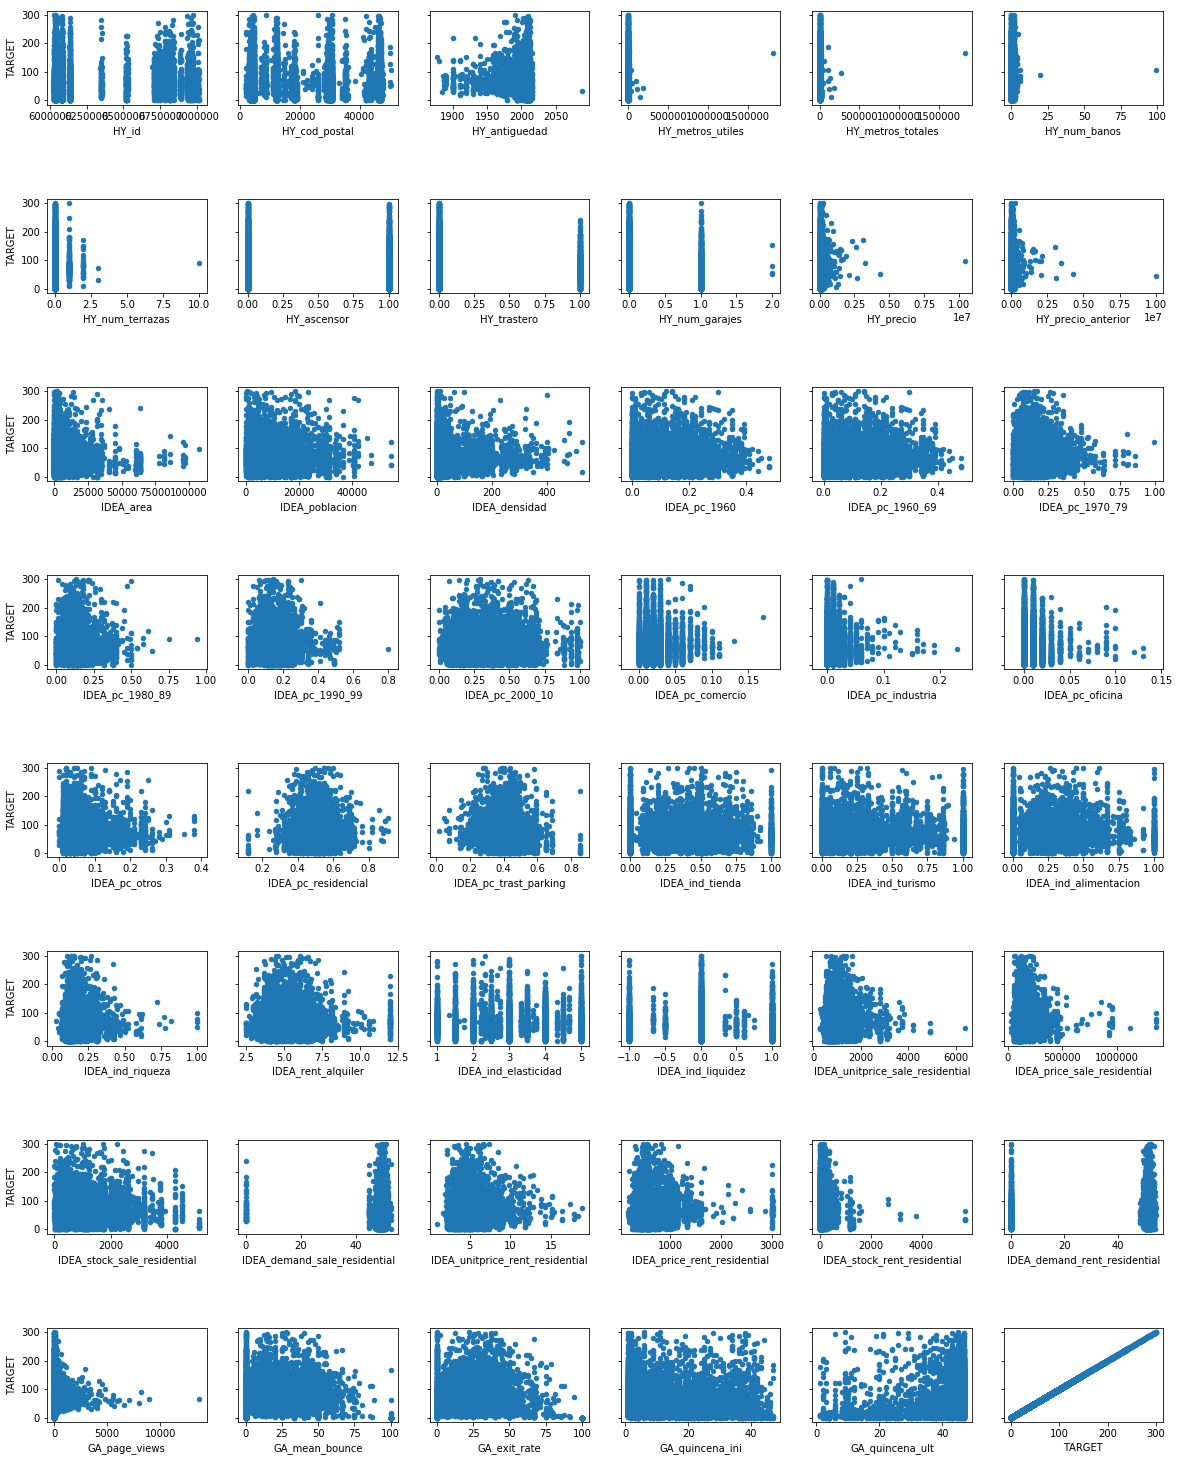

In [27]:
fig, axes = plt.subplots(nrows=8, ncols=6,figsize=(20, 20))
plt.subplots_adjust(top = 0.99, bottom=0.01, hspace=1, wspace=0.2)

j=0
k=0
for i in modelar.columns:
    try:
        modelar[[i, 'TARGET']].plot(x = i, y = 'TARGET', kind = 'scatter',ax=axes[j, k],sharey=True,sharex=False)
        k+=1
        if k==6:
            k=0
            j+=1
    except:
        print(i, 'plot not possible')

<a id='correlationmatrix'></a> 

#### 3.3. Matriz de correlaciones <p style="text-align: right;"> <a href='#top'>Return to top</a> </p>


In [28]:
from sklearn.feature_selection import mutual_info_classif as MIc
from sklearn.feature_selection import mutual_info_regression as MIr

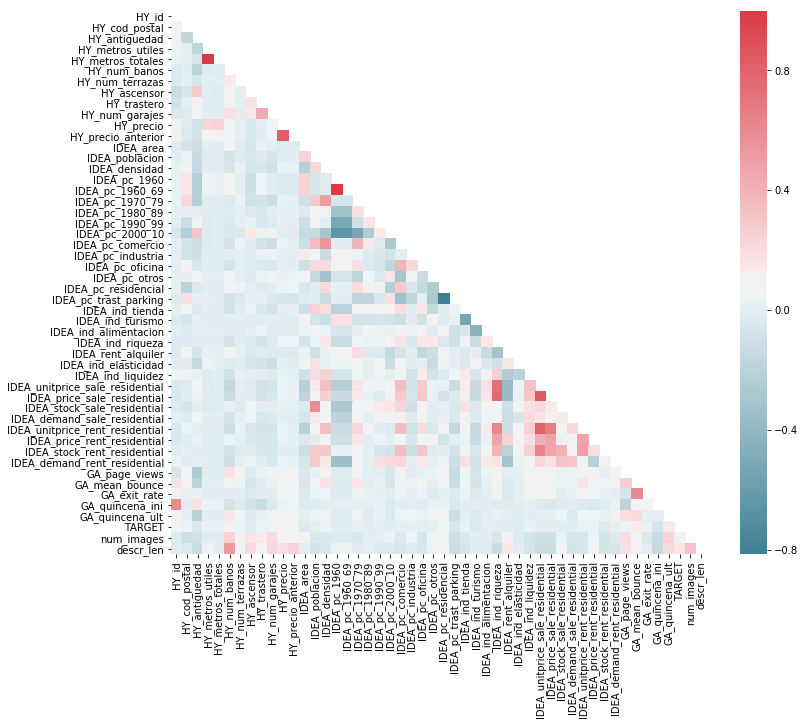

In [29]:
fig, ax = plt.subplots(figsize = (12, 10))
corr_matrix = modelar.corr()
mask = np.zeros_like(corr_matrix, dtype=np.bool)
mask[np.triu_indices_from(mask)] = True
sns.heatmap(corr_matrix, cmap = sns.diverging_palette(220, 10, as_cmap = True), mask = mask)
plt.show()

In [30]:
columnas= modelar.columns

position=[i for i,x in enumerate(columnas) if x == 'HY_precio']
modelar.insert(position[0]+1, '% Descuento', 0)
modelar['% Descuento'] = np.where(modelar['HY_precio_anterior']>0, 100*round(((modelar['HY_precio']-modelar['HY_precio_anterior'])/modelar['HY_precio_anterior']),4), 0)
modelar[['HY_precio','HY_precio_anterior','% Descuento']].head()

,HY_precio,HY_precio_anterior,% Descuento
0,12300.0,NaN,0.00
1,115000.0,125000.0,-8.00
2,88000.0,93500.0,-5.88
3,5800.0,NaN,0.00
4,7400.0,NaN,0.00


Al tener, la información que aporta *HY_precio_anterior* en una nueva columna *% Descuento*, se procede a eliminarla:

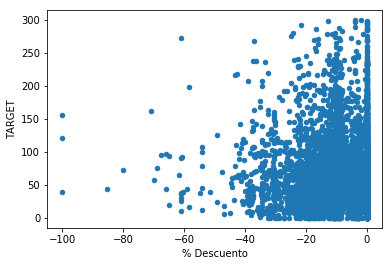

In [31]:
plot_target('% Descuento')

In [32]:
modelar.drop(['HY_precio_anterior'], axis=1, inplace = True)

<a id='categoricalvariables'></a> 

#### 3.4. Variables categóricas <p style="text-align: right;"> <a href='#top'>Return to top</a> </p>


#### Variable: Tipo de anuncio (HY_tipo)
***
A pesar de no disponer de muchos datos de la variable, se observa que no es relevante frente a la variable objetivo

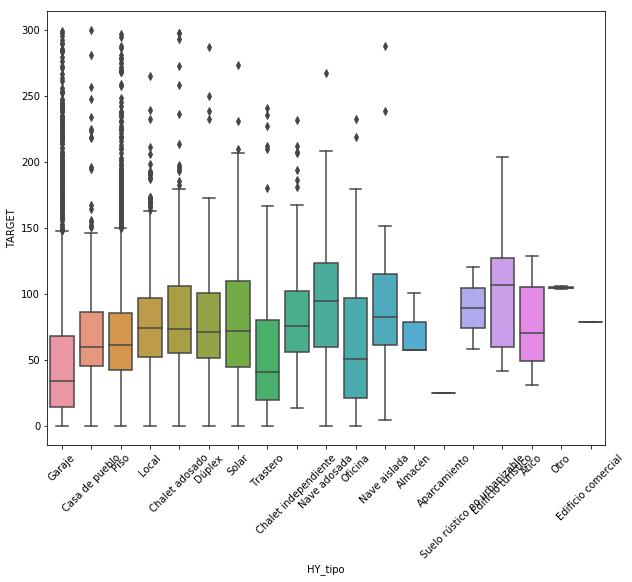

In [33]:
plot_cat_target('HY_tipo')

In [34]:
modelar[['HY_tipo', 'TARGET']].groupby(['HY_tipo']).agg('count')

,TARGET
HY_tipo,
Almacén,3
Aparcamiento,1
Casa de pueblo,443
Chalet adosado,266
Chalet independiente,150
Dúplex,141
Edificio comercial,1
Edificio turístico,11
Garaje,2333


In [35]:
modelar.loc[modelar['HY_tipo']=='Aparcamiento', 'HY_descripcion'].values

array(['Plaza de aparcamiento en superficie, ubicada en el municipio de Fondón, en la provincia de Almería. en una calle peatonal, cerca del centro histórico de la ciudad. El edificio se encuentra en una zona tranquila y cuenta con buenos accesos por carretera y con un nivel alto de servicios y comunicaciones, rodeado de edificios de las mismas características.'],
      dtype=object)

In [36]:
def change_labels(column, old_label, new_label):
    modelar.loc[modelar[column] == old_label, column] = new_label

In [37]:
change_labels('HY_tipo', 'Aparcamiento', 'Garaje')

In [38]:
modelar.loc[modelar['HY_tipo']=='Edificio comercial', 'HY_descripcion'].values

array(['Se trata de un edificio unifamiliar con planta baja y primer piso.'],
      dtype=object)

In [39]:
change_labels('HY_tipo', 'Ático', 'Piso')

In [40]:
modelar.loc[modelar['HY_tipo']=='Suelo rústico no urbanizable', 'HY_descripcion'].values

array(['Terreno urbano de dos hectáreas cuarenta y seis áreas, sobre la que existe una edificación de un chalet aislado compuesto por cuatro dormitorios y un baño. Se encuentra ubicado en el municipio de Chelva, provincia de Valencia.Vivienda distribuida en dos plantas. La planta baja cuenta con un almacén. La planta alta cuenta con cuatro dormitorios, dos baños, un salón comedor con cocina y una terraza.Es un terreno urbano sobre el que existe una edificación de un chalet asilado.Terreno urbano con una edificación de un chalet aislado de dos plantas sobre rasante. Su año de construcción es 1992 y se encuentra ubicado en una zona tranquila. Zona que dispone de centros de educación y ocio, comercios y actividades culturales.Zona con fácil acceso por carretera (N332, CV5040 y CV605), líneas de autobús (urbano e interurbano) y estación de tren (Cercanías Cullera). Cuenta con centros educativos, escuelas infantiles (Escuela Infantil Inmaculada Concepción), colegios públicos (Colegio Públic

In [41]:
change_labels('HY_tipo', 'Suelo rústico no urbanizable', 'Solar')

In [42]:
change_labels('HY_tipo', 'Nave aislada', 'Nave adosada')

In [43]:
change_labels('HY_tipo', 'Edificio comercial', 'Local')

In [44]:
change_labels('HY_tipo', 'Dúplex', 'Piso')

In [45]:
modelar.loc[modelar['HY_tipo']=='Almacén', 'HY_descripcion'].values

array(['Almacén ubicado en la planta baja de un edificio de tres alturas sobre rasante, dos plantas destinadas a viviendas. Se encuentra ubicado en la localidad de Carboneras, provincia de Almería.\r\nEl almacen se distribuye en una estancia diáfana y cuenta con una superficie construida de 58.62 m2 y útil de 54,59m2\r\nEdificio de viviendas de tres alturas sobre rasante, la planta baja destinada a almacén y dos plantas a viviendas. Es del año 1997 y se encuentra ubicado en el municipio de Carboneras a pocos minutos de la playa.\r\nZona con buena comunicación por carretera ( Al-5105, AL-5107) y autobuses urbanos. Cuenta con Hotel Trebol, restauración, centro de salud, centro de buceo, club náutico, ayuntamiento, bancos, supermercados, polideportivo municipal. Cuenta como lugar de interés el Castillo de San Andrés, el Molino de Carboneras y la playa del Lancon.\r\n',
       'Local comercial de una planta de 182 m² construidos, situado en Castellón de la Plana. Se sitúa en la planta baja

In [46]:
change_labels('HY_tipo', 'Chalet pareado', 'Chalet')
change_labels('HY_tipo', 'Chalet independiente', 'Chalet')
change_labels('HY_tipo', 'Chalet adosado', 'Chalet')

In [47]:
modelar.loc[(modelar['HY_tipo'] == 'Almacén') & 
            (modelar['HY_descripcion'] == 'Nave compuesta de una planta, situada en la localidad de Nules, provincia de Castellón.Consta de una superficie de 2654, 74 m².Está compuesta de una planta y se encuentra diáfana. Tiene estructura de metal y placas traslucidas en el techo.La nave se encuentra rodeada por edificaciones y naves de similares características.Tiene una antigüedad del año 1972. A 18 km de Castellón, cuenta con fácil acceso a través de la carretera CV-231 que enlaza con la autovía A-7. Está próxima al Teatro Alcázar, los Juzgados de Nules, y de la estación de Renfe de Cercanías de Nules- La Vilavella y a su alrededor encontrar gran variedad de servicios como comercios, centros educativos, centros de salud, farmacias, cajeros, bares y restaurantes. Nules es una localidad costera del sur de la provincia de Castellón, localizada en la comarca de la Plana Baja. Su clima es mediterráneo. Nules dispone de un amplio litoral, de unos 5 km de longitud que junto a la playa de Nules, es un ejemplo deplaya sostenible y sin aglomeraciones, Además, se puede visitar el paraje natural del Estany de Nules, una laguna de agua dulce habitada por numerosas especies de aves y peces.'), 'HY_tipo'] = 'Nave'

In [48]:
modelar.loc[(modelar['HY_tipo'] == 'Almacén') & 
            (modelar['HY_descripcion'] == 'Local comercial de una planta de 182 m² construidos, situado en Castellón de la Plana. Se sitúa en la planta baja de un edificio residencial de diez alturas y dos plantas sobre rasante incluido garaje.El local consta de una planta, con vestíbulo, aseo y garaje, teniendo una superficie de 182 m² construidos. Se trata de un local en buen estado de conservación y con buena accesibilidad. Posee un vestíbulo, aseo y garaje. El inmueble posee persianas de aluminio y en el aseo porcelana vitrificada blanca. El local se localiza en la planta baja de un edificio residencial de diez plantas sobre rasante y se haya rodeado de locales y viviendas de similarescaracterísticas. Su año de construcción es 1997. Se encuentra ubicado en la ciudad de Castellón de la Plana, en zona tranquila a 10 min del centroCastellón de la Plana es una ciudad y municipio español, capital de la provincia de Castellón y de la comarca, situado en la Comunidad Valenciana. Situado al este de la península sobre una extensión de terreno llano, rodeada por distintas sierras por el interior y el mar Mediterráneo al este, ante el cual se extienden los 10 kilómetros de costa. El núcleo urbano principal se encuentra a unos 30 m sobre el nivel del mar y a unos 4 km de la costa. Castellón se encuentra comunicada con el resto de la península a través de la Autopista AP-7 que cruza la provincia de norte a sur, y por la carretera nacional paralela, la N-340 que comunica todo el mediterráneo español.  Hacia el interior de la península A-23 comunica Valencia con Aragón y la N-232, hasta Soria, pasando por Morella. Las conexiones ferroviarias recorren Valencia, Alicante y Madrid, como con Tarragona, Barcelona y Europa. Además, posee una gran variedad de medios de transporte a través de los cuales puedes moverte por toda la ciudad de manera rápida y cómoda. Dispone de 12 líneas y de los autobuses urbanos para desplazamientos y red de tram. El local cuenta en las cercanías con varias líneas de autobuses (L-8, L-11, L-4 y L-17), además de multitud de comercios y restaurantes, centros educativos (IES el Caminas),  hospitales (Hospital provincial de Castellón), centros comerciales cercanos y comisarias.'), 'HY_tipo'] = 'Local'

In [49]:
modelar.loc[(modelar['HY_tipo'] == 'Almacén') & 
            (modelar['HY_descripcion'] == 'Almacén ubicado en la planta baja de un edificio de tres alturas sobre rasante, dos plantas destinadas a viviendas. Se encuentra ubicado en la localidad de Carboneras, provincia de Almería.\r\nEl almacen se distribuye en una estancia diáfana y cuenta con una superficie construida de 58.62 m2 y útil de 54,59m2\r\nEdificio de viviendas de tres alturas sobre rasante, la planta baja destinada a almacén y dos plantas a viviendas. Es del año 1997 y se encuentra ubicado en el municipio de Carboneras a pocos minutos de la playa.\r\nZona con buena comunicación por carretera ( Al-5105, AL-5107) y autobuses urbanos. Cuenta con Hotel Trebol, restauración, centro de salud, centro de buceo, club náutico, ayuntamiento, bancos, supermercados, polideportivo municipal. Cuenta como lugar de interés el Castillo de San Andrés, el Molino de Carboneras y la playa del Lancon.\r\n'), 'HY_tipo'] = 'Local'

In [50]:
change_labels('HY_tipo', 'Nave adosada', 'Nave')

In [51]:
change_labels('HY_tipo', 'Edificio turístico', 'Otro')

In [52]:
modelar[['HY_tipo', 'TARGET']].groupby(['HY_tipo']).agg('count')

,TARGET
HY_tipo,
Casa de pueblo,443
Chalet,416
Garaje,2334
Local,703
Nave,137
Oficina,69
Otro,13
Piso,3227
Solar,154


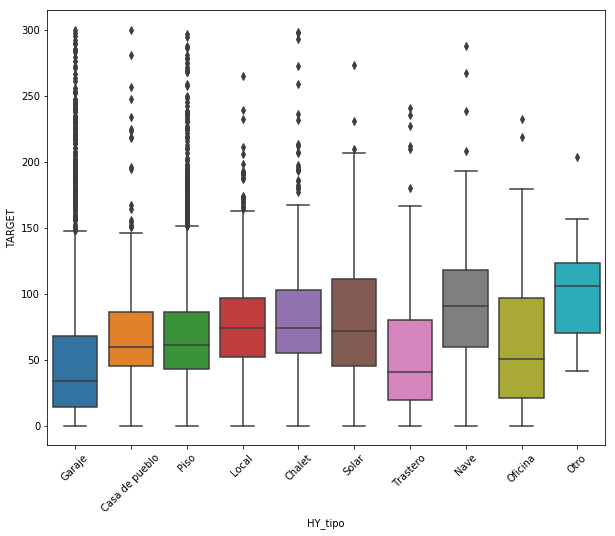

In [53]:
plot_cat_target('HY_tipo')

<a id='dataprep'></a> 

### 4. Preparación de los datos <p style="text-align: right;"> <a href='#top'>Return to top</a> </p>


<a id='fillna'></a> 

#### 4.1. Imputación de valores no disponibles <p style="text-align: right;">

In [54]:
cols = modelar.columns.tolist()

In [55]:
idealista_vars = [col for col in cols if col[:4]=='IDEA']

In [56]:
idealista_vars.append('HY_provincia')

In [57]:
to_fill_missing_values_prov = modelar[idealista_vars].groupby(by = 'HY_provincia').agg(['median'])

In [58]:
to_fill_missing_values_prov

,IDEA_area,IDEA_poblacion,IDEA_densidad,IDEA_pc_1960,IDEA_pc_1960_69,IDEA_pc_1970_79,IDEA_pc_1980_89,IDEA_pc_1990_99,IDEA_pc_2000_10,IDEA_pc_comercio,...,IDEA_ind_elasticidad,IDEA_ind_liquidez,IDEA_unitprice_sale_residential,IDEA_price_sale_residential,IDEA_stock_sale_residential,IDEA_demand_sale_residential,IDEA_unitprice_rent_residential,IDEA_price_rent_residential,IDEA_stock_rent_residential,IDEA_demand_rent_residential
,median,median,median,median,median,median,median,median,median,median,...,median,median,median,median,median,median,median,median,median,median
HY_provincia,,,,,,,,,,,,,,,,,,,,,
A Coruña,223.510,11517.0,51.530,0.080,0.080,0.270,0.200,0.070,0.310,0.060,...,1.000000,0.000000,1848.910,198996.670,1071.0,49.210,8.120,1015.560,195.0,51.920
Albacete,34969.490,11882.0,0.340,0.050,0.050,0.150,0.120,0.160,0.310,0.015,...,2.333333,0.166667,1354.280,201047.060,1188.0,49.230,5.020,663.360,339.0,50.530
Alicante,2017.490,7501.0,2.850,0.110,0.110,0.170,0.120,0.130,0.250,0.030,...,3.000000,0.000000,940.320,128381.500,1083.0,49.090,4.640,560.500,51.0,51.550
Almería,1234.100,10648.0,5.180,0.010,0.010,0.100,0.140,0.180,0.470,0.020,...,3.000000,0.000000,940.430,116817.690,999.0,49.210,4.590,447.690,51.0,51.400
Asturias,119.450,15246.0,127.640,0.090,0.090,0.400,0.120,0.120,0.200,0.050,...,4.000000,0.000000,1595.080,287118.750,1575.0,49.090,7.590,575.140,489.0,50.530
Avila,79.560,7834.0,67.460,0.090,0.090,0.260,0.180,0.220,0.120,0.030,...,1.500000,0.000000,867.580,100653.750,918.0,49.395,5.060,488.730,99.0,51.265
Baleares,3109.030,7053.0,1.500,0.270,0.270,0.090,0.090,0.070,0.200,0.020,...,2.500000,0.000000,1337.160,214251.560,828.0,50.200,6.795,1109.205,153.0,51.540
Barcelona,378.460,12217.0,55.270,0.080,0.080,0.230,0.090,0.130,0.220,0.040,...,3.000000,0.000000,1710.490,235926.470,804.0,50.150,8.500,893.120,87.0,52.170


In [59]:
to_fill_missing_values = modelar.loc[modelar['HY_provincia'].notnull(), idealista_vars].mean()

In [60]:
idealista_vars = [col for col in cols if col[:4]=='IDEA']
provincias = to_fill_missing_values_prov.index.values.tolist()

In [61]:
for col in idealista_vars:
    for provincia in provincias:
        modelar.loc[(modelar['HY_provincia'] == provincia) & (modelar[col].isnull()), col] = to_fill_missing_values_prov.loc[provincia, col].values[0]

In [62]:
modelar = modelar.loc[modelar['IDEA_pc_1960'].notnull()]

In [63]:
to_fill_missing_values_tipo = modelar[['HY_metros_totales', 'HY_tipo']].groupby(by = 'HY_tipo').agg(['median'])
to_fill_missing_values_tipo

,HY_metros_totales
,median
HY_tipo,
Casa de pueblo,132.710
Chalet,154.255
Garaje,25.000
Local,136.730
Nave,604.420
Oficina,107.000
Otro,475.920
Piso,88.000


In [64]:
tipos = to_fill_missing_values_tipo.index.values.tolist()

In [65]:
for tipo in tipos:
        modelar.loc[(modelar['HY_tipo'] == tipo) & (modelar['HY_metros_totales'].isnull()), 'HY_metros_totales'] = to_fill_missing_values_tipo.loc[tipo, 'HY_metros_totales'].values[0]

In [66]:
modelar.loc[modelar['IDEA_rent_alquiler'].isnull(), 'IDEA_rent_alquiler'] = modelar['IDEA_rent_alquiler'].median()

In [67]:
modelar = modelar[modelar['IDEA_unitprice_rent_residential'].notnull()]

In [68]:
modelar.loc[modelar['descr_len'].isnull(), 'descr_len'] = 0

In [69]:
modelar.isnull().sum()

HY_id                                 0
HY_cod_postal                         0
HY_provincia                         36
HY_descripcion                     1915
HY_distribucion                    4643
HY_tipo                               0
HY_antiguedad                      3387
HY_metros_utiles                   2256
HY_metros_totales                     0
HY_num_banos                          0
HY_cert_energ                      6098
HY_num_terrazas                       0
HY_ascensor                           0
HY_trastero                           0
HY_num_garajes                        0
HY_precio                             0
% Descuento                           0
IDEA_area                             0
IDEA_poblacion                        0
IDEA_densidad                         0
IDEA_pc_1960                          0
IDEA_pc_1960_69                       0
IDEA_pc_1970_79                       0
IDEA_pc_1980_89                       0
IDEA_pc_1990_99                       0


<a id='dropvariables'></a> 

#### 4.3. Eliminación de atributos sin relevancia <p style="text-align: right;"> <a href='#top'>Return to top</a> </p>


In [70]:
modelar_clean = modelar.drop(['HY_descripcion','HY_distribucion','HY_cod_postal','HY_provincia',
                            'HY_cert_energ','HY_ascensor', 'HY_antiguedad', 'HY_metros_utiles',
                            'IDEA_ind_elasticidad', 'IDEA_ind_liquidez'],axis=1)

In [71]:
# modelar_clean.to_csv('data/modelar_clean.csv')

In [73]:
modelar_clean.drop('HY_id', axis=1, inplace=True)

In [74]:
modelar_clean.isnull().sum()

HY_tipo                            0
HY_metros_totales                  0
HY_num_banos                       0
HY_num_terrazas                    0
HY_trastero                        0
HY_num_garajes                     0
HY_precio                          0
% Descuento                        0
IDEA_area                          0
IDEA_poblacion                     0
IDEA_densidad                      0
IDEA_pc_1960                       0
IDEA_pc_1960_69                    0
IDEA_pc_1970_79                    0
IDEA_pc_1980_89                    0
IDEA_pc_1990_99                    0
IDEA_pc_2000_10                    0
IDEA_pc_comercio                   0
IDEA_pc_industria                  0
IDEA_pc_oficina                    0
IDEA_pc_otros                      0
IDEA_pc_residencial                0
IDEA_pc_trast_parking              0
IDEA_ind_tienda                    0
IDEA_ind_turismo                   0
IDEA_ind_alimentacion              0
IDEA_ind_riqueza                   0
I

<a id='dummies'></a> 

#### 4.2. Variables Dummy <p style="text-align: right;"> <a href='#top'>Return to top</a> </p>


In [79]:
categorical_cols = ['HY_tipo']

In [81]:
modelar_clean = pd.get_dummies(modelar_clean, prefix=None, prefix_sep='_', dummy_na=False, columns=categorical_cols)

<a id='featureselection'></a> 

### 5. Selección de variables <p style="text-align: right;"> <a href='#top'>Return to top</a> </p>


In [82]:
y = modelar_clean['TARGET']
X = modelar_clean.drop('TARGET', axis = 1)

In [87]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

In [92]:
with open('data/train_test/X_train.npy', 'w') as f:
    np.save('data/train_test/X_train.npy',X_train)
with open('data/train_test/y_train.npy', 'w') as f:
    np.save('data/train_test/y_train.npy',y_train)
with open('data/train_test/X_test.npy', 'w') as f:
    np.save('data/train_test/X_test.npy',X_test)
with open('data/train_test/y_test.npy', 'w') as f:
    np.save('data/train_test/y_test.npy',y_test)

In [116]:
rf_model = RandomForestRegressor(n_estimators = 500, criterion = 'mse', min_samples_split = 8)

In [117]:
rf_model.fit(X_train, y_train)
print(rf_model.feature_importances_)

[0.05654037 0.0062377  0.00288752 0.00240313 0.00149023 0.05543898
 0.04095362 0.02085906 0.01783926 0.01254888 0.005256   0.00509585
 0.01092854 0.01390256 0.01183101 0.0146815  0.00485739 0.00488052
 0.00359306 0.01766876 0.01097374 0.01175939 0.01499827 0.01223661
 0.01188543 0.00823849 0.02053814 0.01163623 0.01228762 0.01704392
 0.01685557 0.01495184 0.01496222 0.01115073 0.01942829 0.14095204
 0.03218713 0.12725657 0.04345205 0.04614138 0.02209577 0.04074795
 0.00191111 0.00961008 0.00450849 0.00231803 0.00375309 0.00217143
 0.00019422 0.00180238 0.00128178 0.00077605]


In [118]:
names = X.columns.tolist()
print(sorted(zip(map(lambda x: round(x, 4), rf_model.feature_importances_), names), reverse=True))

[(0.141, 'GA_page_views'), (0.1273, 'GA_exit_rate'), (0.0565, 'HY_metros_totales'), (0.0554, 'HY_precio'), (0.0461, 'GA_quincena_ult'), (0.0435, 'GA_quincena_ini'), (0.041, '% Descuento'), (0.0407, 'descr_len'), (0.0322, 'GA_mean_bounce'), (0.0221, 'num_images'), (0.0209, 'IDEA_area'), (0.0205, 'IDEA_rent_alquiler'), (0.0194, 'IDEA_demand_rent_residential'), (0.0178, 'IDEA_poblacion'), (0.0177, 'IDEA_pc_otros'), (0.017, 'IDEA_stock_sale_residential'), (0.0169, 'IDEA_demand_sale_residential'), (0.015, 'IDEA_unitprice_rent_residential'), (0.015, 'IDEA_price_rent_residential'), (0.015, 'IDEA_ind_tienda'), (0.0147, 'IDEA_pc_2000_10'), (0.0139, 'IDEA_pc_1980_89'), (0.0125, 'IDEA_densidad'), (0.0123, 'IDEA_price_sale_residential'), (0.0122, 'IDEA_ind_turismo'), (0.0119, 'IDEA_ind_alimentacion'), (0.0118, 'IDEA_pc_trast_parking'), (0.0118, 'IDEA_pc_1990_99'), (0.0116, 'IDEA_unitprice_sale_residential'), (0.0112, 'IDEA_stock_rent_residential'), (0.011, 'IDEA_pc_residencial'), (0.0109, 'IDEA_pc

<BarContainer object of 52 artists>

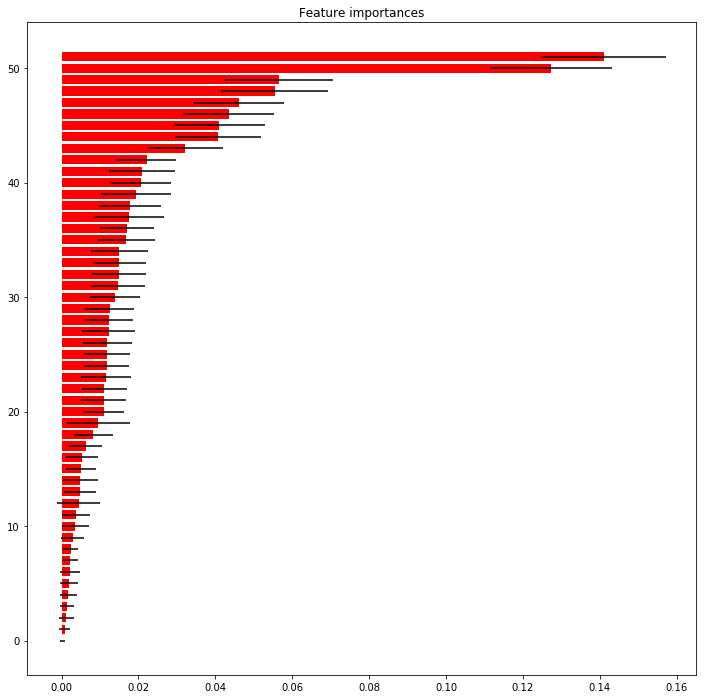

In [119]:
plt.figure(figsize = (12,12))
plt.title("Feature importances")
indices = np.argsort(rf_model.feature_importances_)
std = np.std([tree.feature_importances_ for tree in rf_model.estimators_],
             axis=0)
plt.barh(range(X.shape[1]), rf_model.feature_importances_[indices], color="r", xerr=std[indices], align="center")

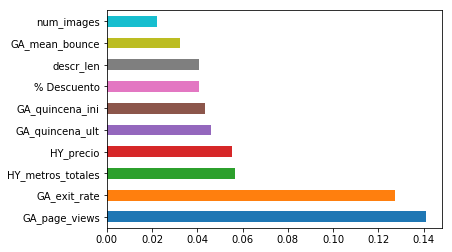

In [120]:
(pd.Series(rf_model.feature_importances_, index=X.columns)
   .nlargest(10)
   .plot(kind='barh'))

<a id='functions'></a>

#### Apéndice 1: Funciones utilizadas <p style="text-align: right;"> <a href='#top'>Return to top</a> </p>
***

### Testing: Mutual information vs. correlation:

In [12]:
d = {'col1': [1,0,1,0,1,0,1,0,1], 'col2': [0,0,0,0,1,1,1,1,1],'Target': [1,1,1,1,0,0,0,0,0]}
df = pd.DataFrame(data=d)
df

,col1,col2,Target
0,1,0,1
1,0,0,1
2,1,0,1
3,0,0,1
4,1,1,0
5,0,1,0
6,1,1,0
7,0,1,0
8,1,1,0


In [13]:
import numpy as np

#Mutual information definition as seen in Info. theory
def MI(X,Y,bins):
   p_XY = np.histogram2d(X,Y,bins)[0]
   p_X = np.histogram(X,bins)[0]
   p_Y = np.histogram(Y,bins)[0]

   H_X = entropy(p_X)
   H_Y = entropy(p_Y)
   H_XY = entropy(p_XY)

   MI = H_X + H_Y - H_XY
   return MI

#Shannon's entropy definition:
def entropy(c):
    c_normalized = c / float(np.sum(c))
    c_normalized = c_normalized[np.nonzero(c_normalized)]
    H = -sum(c_normalized* np.log2(c_normalized))  
    return H

def MI_matrix(A,bins):
    try: 
        A=A.values
        print(A)
    except:
        A=A
    n=A.shape[1]
    matMI = np.zeros((n, n))
    for ix in np.arange(n):
        for jx in np.arange(ix+1,n):
            matMI[ix,jx] = MI(A[:,ix], A[:,jx], bins)
    cmap = sns.diverging_palette(255, 220, as_cmap=True)
    sns.heatmap(matMI.transpose(), cmap=cmap, center=0,
                square=True, linewidths=.5, cbar_kws={"shrink": .5})
    return matMI

#Test. Be careful with unbalanced classes. 
A = np.array([[ 1,  0,  1, 1, 0  ],
              [ 1,  1, 0, 1 , 0 ],
              [ 0,  1,  1, 0, 1 ],
              [0,  1,  1, 0, 1 ],
             [0,  2,  5, 0, 3 ]])

In [14]:
A_df=pd.DataFrame(A)
A_df.corr()

,0,1,2,3,4
0,1.000000,-0.645497,-0.515122,1.000000,-0.745356
1,-0.645497,1.000000,0.725476,-0.645497,0.866025
2,-0.515122,0.725476,1.000000,-0.515122,0.942421
3,1.000000,-0.645497,-0.515122,1.000000,-0.745356
4,-0.745356,0.866025,0.942421,-0.745356,1.000000


,0,1,2,3,4
0,1.000000,-0.645497,-0.515122,1.000000,-0.745356
1,-0.645497,1.000000,0.725476,-0.645497,0.866025
2,-0.515122,0.725476,1.000000,-0.515122,0.942421
3,1.000000,-0.645497,-0.515122,1.000000,-0.745356
4,-0.745356,0.866025,0.942421,-0.745356,1.000000


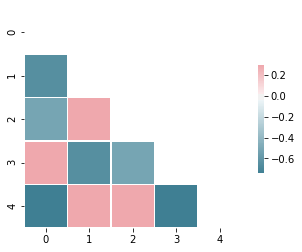

In [15]:
def Corr_Matrix(dataframe):
    a=dataframe.corr()
    # Generate a mask for the upper triangle
    mask = np.zeros_like(a, dtype=np.bool)
    mask[np.triu_indices_from(mask)] = True

    # Generate a custom diverging colormap
    cmap = sns.diverging_palette(220, 10, as_cmap=True)

    sns.heatmap(a, mask=mask, cmap=cmap, vmax=.3, center=0,
                square=True, linewidths=.5, cbar_kws={"shrink": .5})
    return a
Corr_Matrix(A_df)

array([[0.        , 0.41997309, 0.41997309, 0.97095059, 0.97095059],
       [0.        , 0.        , 0.81997309, 0.41997309, 0.97095059],
       [0.        , 0.        , 0.        , 0.41997309, 0.97095059],
       [0.        , 0.        , 0.        , 0.        , 0.97095059],
       [0.        , 0.        , 0.        , 0.        , 0.        ]])

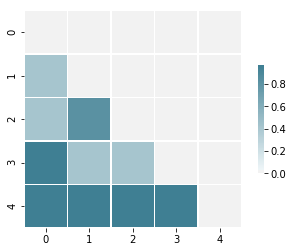

In [16]:
MI_matrix(A,bins=10)

In [17]:
test=modelar[['HY_num_banos','TARGET']]
test.head()

,HY_num_banos,TARGET
0,0,32.16
1,2,30.71
2,1,63.48
3,0,108.27
4,0,7.50


# Test MI vs F-test:

https://scikit-learn.org/stable/auto_examples/feature_selection/plot_f_test_vs_mi.html